# Multi-output neural networks

We would like to try to predict all outputs at once using multi-output neural networks. The outputs have different activation functions and different losses that should be applied to each one of them. With neural networks, we create a model adapted to each output.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from tensorflow import keras
from keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scikeras.wrappers import KerasRegressor

In [80]:
path = './Files/After_Feature_Engineering/Split/'

#### Helper functions

In [81]:
def label_encoder(Y_train, Y_test):
    """
    Encode categorical labels using LabelEncoder and convert them to one-hot encoding.

    Parameters:
        Y_train (pandas.DataFrame): Training labels.
        Y_test (pandas.DataFrame): Testing labels.

    Returns:
        Tuple of encoded and one-hot encoded labels for nail spacing, number of sheathing panels,
        number of end studs, as well as the original Y_train and Y_test.
    """
    # Encode and one-hot encode 'Nail spacing [cm]'
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    # Encode and one-hot encode 'Number sheathing panels'
    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    # Encode and one-hot encode 'Number end studs'
    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    # Return the results
    return (
        Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing,
        Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels,
        Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs,
        Y_train, Y_test
    )

def print_results(best_hps, model, evaluation_results):
    """
    Prints the best hyperparameters, model metrics, and evaluation results.

    Parameters:
    - best_hps (dict): Dictionary containing the best hyperparameters.
    - model (keras.Model): The trained model.
    - evaluation_results (list): List of evaluation results on the test set.

    Returns:
    None
    """
    print("Best Hyperparameters:")
    for key, value in best_hps.values.items():
        print(f"{key}: {value}")
        
    print('---------------------------------------------')
    output_metrics = {name: value for name, value in zip(model.metrics_names, evaluation_results)}
    print("Metrics on Test Set:")
    for output_name, metric_value in output_metrics.items():
        print(f"{output_name}: {metric_value}")

def learning_rate(hp):
    """
    Define a learning rate schedule using an exponential decay.

    Parameters:
    - hp: HyperParameters object for hyperparameter tuning.

    Returns:
    - ExponentialDecay learning rate schedule.
    """
    return keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay_steps=10000,
        decay_rate=0.9)

def retrain_tuner(tuner_dir, re_run=True):
    """
    Retrain the tuner if it already exists.

    Parameters:
    - tuner_dir (str): Path to the directory of the tuner.
    - re_run (bool): Whether to retrain the tuner or not.

    Returns:
    - None
    """
    if os.path.exists(tuner_dir) and re_run == True:
        shutil.rmtree(tuner_dir)

# Visualization functions
def plot_loss(history):
    """
    Plot training and validation loss over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for output in history.history.keys():
        if output.endswith('loss') and not output.startswith('val_') and output != 'loss':
            plt.plot(history.history[output], label=output)

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for output in history.history.keys():
        if output.startswith('val_') and output.endswith('loss') and output != 'val_loss':
            plt.plot(history.history[output], label=output[4:])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


## 1. Predicting wall specification (Type C)

In [ ]:
X_train_C_1 = pd.read_csv(path + "X_train_C_part1_FE.csv", low_memory=False)
X_test_C_1 = pd.read_csv(path + "X_test_C_part1_FE.csv", low_memory=False)

Y_train_C_1 = pd.read_csv(path + "Y_train_C_part1_FE.csv", low_memory=False)
Y_test_C_1 = pd.read_csv(path + "Y_test_C_part1_FE.csv", low_memory=False)

In [ ]:
# Defining constants
input_layer_C_1 = Input(shape=(X_train_C_1.shape[1],))
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

losses_dict_C_1 = {'nail_spacing': 'categorical_crossentropy',
                'num_sheathing_panels': 'categorical_crossentropy',
                'num_end_studs': 'categorical_crossentropy',
                'total_num_studs': 'mean_squared_error',
                'holddown/ats': 'mean_squared_error'
                }
metrics_dict_C_1 = {'nail_spacing': 'accuracy',
                'num_sheathing_panels': 'accuracy',
                'num_end_studs': 'accuracy',
                'total_num_studs': 'mae',
                'holddown/ats': 'mae'
                }
Y_train_distribution_C_1 = {'nail_spacing': Y_train_onehot_nail_spacing, 
                        'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                        'num_end_studs': Y_train_onehot_num_end_studs,
                        'total_num_studs': Y_train_C_1['Total number studs'],
                        'holddown/ats': Y_train_C_1['HoldDown Model / ATS']
                        }
Y_test_distribution_C_1 = {'nail_spacing': Y_test_onehot_nail_spacing,
                        'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                        'num_end_studs': Y_test_onehot_num_end_studs,
                        'total_num_studs': Y_test_C_1['Total number studs'],
                        'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                        }

### 1. Base implementation

Epoch 1/10
1557/1557 [==============================] - 40s 20ms/step - loss: 84.2160 - nail_spacing_loss: 0.7119 - num_sheathing_panels_loss: 0.3160 - num_end_studs_loss: 0.9447 - total_num_studs_loss: 52.3115 - holddown/ats_loss: 29.9319 - nail_spacing_accuracy: 0.7075 - num_sheathing_panels_accuracy: 0.8752 - num_end_studs_accuracy: 0.6836 - total_num_studs_mae: 5.4773 - holddown/ats_mae: 3.4661 - val_loss: 44.5329 - val_nail_spacing_loss: 0.6370 - val_num_sheathing_panels_loss: 0.2697 - val_num_end_studs_loss: 0.7336 - val_total_num_studs_loss: 20.6445 - val_holddown/ats_loss: 22.2481 - val_nail_spacing_accuracy: 0.7372 - val_num_sheathing_panels_accuracy: 0.8918 - val_num_end_studs_accuracy: 0.7617 - val_total_num_studs_mae: 3.2229 - val_holddown/ats_mae: 3.1656 - lr: 0.0010
Epoch 2/10
1557/1557 [==============================] - 41s 26ms/step - loss: 36.1915 - nail_spacing_loss: 0.6109 - num_sheathing_panels_loss: 0.2572 - num_end_studs_loss: 0.6733 - total_num_studs_loss: 16.160

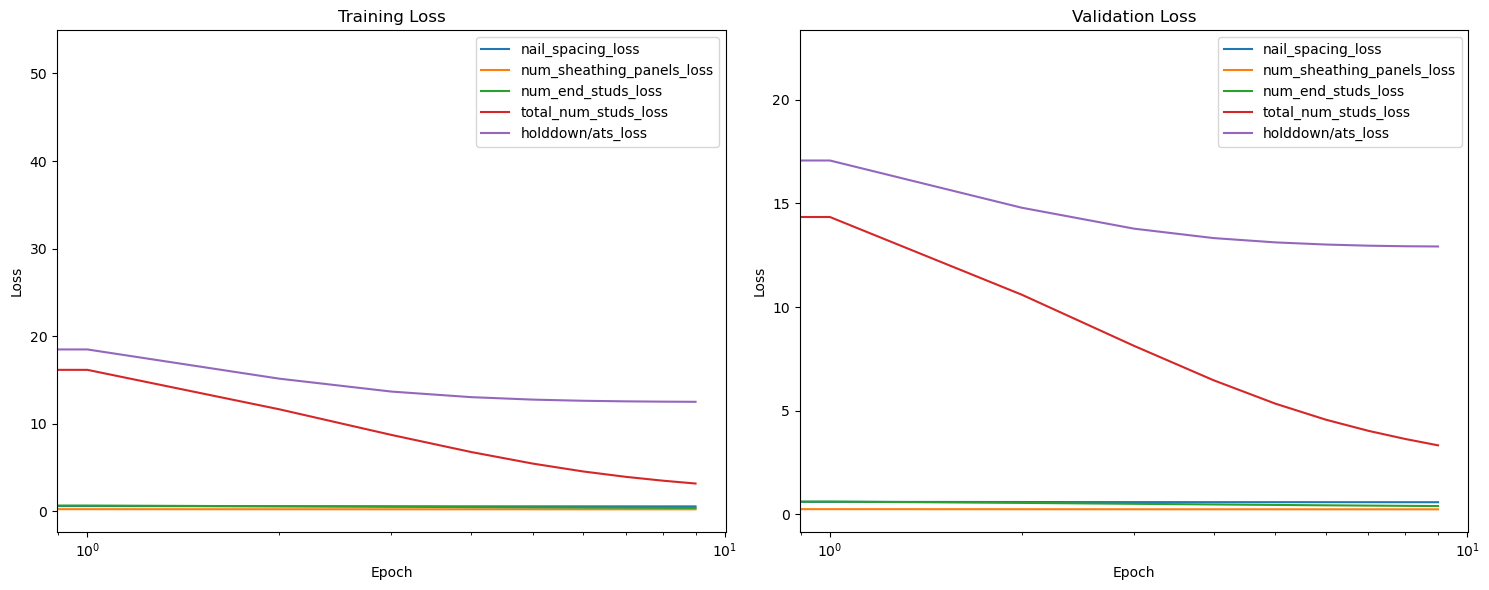

In [ ]:
# Output layers
nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(input_layer_C_1)
num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(input_layer_C_1)
num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(input_layer_C_1)
total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(input_layer_C_1)
holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(input_layer_C_1)

# Combine the outputs into a single model
model_C_1 = Model(inputs=input_layer_C_1, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                           num_end_studs_output, total_num_studs_output, 
                                           holddown_model_output])

# Compile the model
model_C_1.compile(optimizer='adam', loss=losses_dict_C_1, metrics=metrics_dict_C_1)

# Implement ReduceLROnPlateau callback
# Went from 0.02 to 0.008 in total loss with this line
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_1 = model_C_1.fit(X_train_C_1, Y_train_distribution_C_1,
                                epochs=10, batch_size=32, validation_data = (X_test_C_1, Y_test_distribution_C_1), callbacks=[reduce_lr])

# Plot training and validation loss
plot_loss(history_C_1)

In [ ]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, Y_test_distribution_C_1, batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 2s 4ms/step - loss: 17.5018 - nail_spacing_loss: 0.5904 - num_sheathing_panels_loss: 0.2479 - num_end_studs_loss: 0.4063 - total_num_studs_loss: 3.3335 - holddown/ats_loss: 12.9238 - nail_spacing_accuracy: 0.7513 - num_sheathing_panels_accuracy: 0.8907 - num_end_studs_accuracy: 0.8428 - total_num_studs_mae: 1.2492 - holddown/ats_mae: 2.6468
Metrics on Test Set:
loss: 17.50182342529297
nail_spacing_loss: 0.5903915762901306
num_sheathing_panels_loss: 0.2479044646024704
num_end_studs_loss: 0.4062564969062805
total_num_studs_loss: 3.333475351333618
holddown/ats_loss: 12.923799514770508
nail_spacing_accuracy: 0.7513049244880676
num_sheathing_panels_accuracy: 0.8907090425491333
num_end_studs_accuracy: 0.8427687883377075
total_num_studs_mae: 1.2492305040359497
holddown/ats_mae: 2.6468288898468018


### 2. Tuning the model's layers and hyperparameters

#### Hyperparameter Tuning with Keras Tuner

In this code, we are using Keras Tuner to perform hyperparameter tuning for a multi-output neural network (model_C_1). The goal is to find the optimal hyperparameters that minimize the validation loss. Here's an explanation of the key components:

##### Tuner Directory Setup
We define a directory (`tuner_dir_C_1`) to store the results of the hyperparameter tuning. If the directory exists, it is deleted to ensure a clean start.

##### Build Model Function
The `build_model_C_1` function defines the architecture of the neural network. Hyperparameters tuned include the number and size of dense layers, activation functions, regularization terms, dropout rates, and learning rate schedule.

##### Hyperband Tuner Initialization
We create an instance of the `Hyperband` tuner from Keras Tuner. Hyperband is an optimization algorithm that uses adaptive resource allocation to efficiently explore the hyperparameter space. It conducts multiple trials with different hyperparameter configurations.

- **Objective:** Minimize the validation loss (`val_loss`).
- **Max Epochs:** Maximum number of training epochs for each model.
- **Factor:** Reduction factor that determines the number of models trained in each bracket.

##### Hyperparameter Search
The `search` method of the tuner is used to perform a search over the hyperparameter space. It trains models with different hyperparameter configurations on the training data (`X_train_C_1` and `Y_train_C_1`). The validation data (`X_test_C_1` and `Y_test_C_1`) is used for evaluating the models.

##### Best Hyperparameters and Model
After the hyperparameter search, we retrieve the best hyperparameters (`best_hps_C_1`) and the best model (`best_model`). The best hyperparameters are the ones that resulted in the lowest validation loss during the search.

**Note:** The details of the hyperparameter configuration and model architecture are determined by the search process.  
**Important note:** If you wish to not retrain the tuner of a particular model, you need to set the parameter re_run to False for the function `retrain_tuner` in the corresponding cell.

This process allows us to systematically explore and optimize the hyperparameters of our neural network, improving its performance on the given task.


In [ ]:
tuner_dir_C_1 = 'my_dir/multi_output_tuning_reduced_C_1'
retrain_tuner(tuner_dir_C_1, re_run=True)

def build_model_C_1(hp):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    x = input_layer

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_constructed_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                  activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.3, step=0.1))(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    lr_schedule = learning_rate(hp)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=losses_dict_C_1, metrics=metrics_dict_C_1)

    return model

# Create a tuner instance
tuner_C_1 = kt.Hyperband(build_model_C_1,
                     objective='val_loss',
                     max_epochs=15,
                     factor=5,
                     directory='my_dir',
                     project_name='multi_output_tuning_reduced_C_1')

# Start the hyperparameter search
tuner_C_1.search(X_train_C_1, Y_train_distribution_C_1, epochs=15, validation_data=(X_test_C_1, Y_test_distribution_C_1))

# Get the best hyperparameters
best_hps = tuner_C_1.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 04m 41s]
val_loss: 3.842426300048828

Best val_loss So Far: 3.6518397331237793
Total elapsed time: 00h 38m 19s


In [ ]:
best_model = tuner_C_1.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
evaluation_results_C_1 = best_model.evaluate(X_test_C_1, Y_test_distribution_C_1)

# Re-train the best model
best_hps = tuner_C_1.get_best_hyperparameters(num_trials=1)[0]
model_C_1 = build_model_C_1(best_hps)
history_C_1 = model_C_1.fit(X_train_C_1, Y_train_distribution_C_1, epochs=200, validation_data=(X_test_C_1, Y_test_distribution_C_1))

390/390 [==============================] - 6s 10ms/step - loss: 3.6518 - nail_spacing_loss: 0.5285 - num_sheathing_panels_loss: 0.2246 - num_end_studs_loss: 0.2858 - total_num_studs_loss: 0.8416 - holddown/ats_loss: 1.7714 - nail_spacing_accuracy: 0.7661 - num_sheathing_panels_accuracy: 0.8869 - num_end_studs_accuracy: 0.8818 - total_num_studs_mae: 0.6129 - holddown/ats_mae: 0.7349
Epoch 1/200
1557/1557 [==============================] - 30s 16ms/step - loss: 16.0369 - nail_spacing_loss: 0.6856 - num_sheathing_panels_loss: 0.3018 - num_end_studs_loss: 0.5199 - total_num_studs_loss: 8.6507 - holddown/ats_loss: 5.8789 - nail_spacing_accuracy: 0.7104 - num_sheathing_panels_accuracy: 0.8619 - num_end_studs_accuracy: 0.7976 - total_num_studs_mae: 1.7548 - holddown/ats_mae: 1.4973 - val_loss: 5.7535 - val_nail_spacing_loss: 0.6053 - val_num_sheathing_panels_loss: 0.2558 - val_num_end_studs_loss: 0.3780 - val_total_num_studs_loss: 1.5533 - val_holddown/ats_loss: 2.9611 - val_nail_spacing_accu

In [ ]:
# Print the evaluation results and best hyperparameters for model C_1
print_results(best_hps, model_C_1, evaluation_results_C_1)

Best Hyperparameters:
num_constructed_layers: 3
units_0: 64
dropout_0: 0.0
initial_learning_rate: 0.00353332901342474
tuner/epochs: 15
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
units_1: 32
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
tuner/trial_id: 0000
---------------------------------------------
Metrics on Test Set:
loss: 3.6518397331237793
nail_spacing_loss: 0.5284690856933594
num_sheathing_panels_loss: 0.22461286187171936
num_end_studs_loss: 0.28583279252052307
total_num_studs_loss: 0.8415675163269043
holddown/ats_loss: 1.7713568210601807
nail_spacing_accuracy: 0.7660804390907288
num_sheathing_panels_accuracy: 0.8869348764419556
num_end_studs_accuracy: 0.8817955255508423
total_num_studs_mae: 0.612890899181366
holddown/ats_mae: 0.7349128127098083


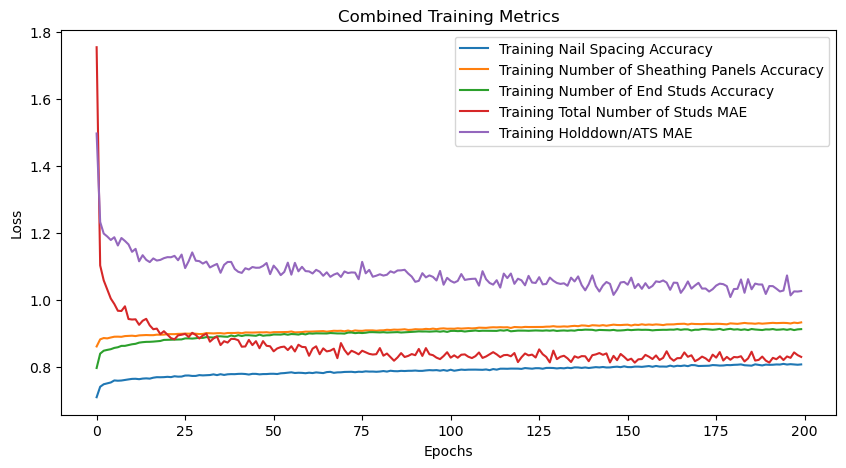

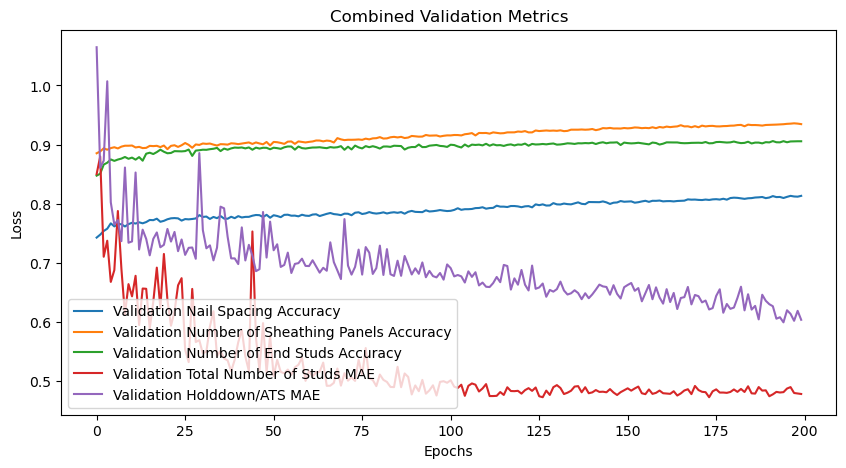

In [ ]:
def plot_combined_metrics(history, metrics, titles):
    """
    Plot training and validation metrics over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.
        metrics (list): List of metrics to plot.
        titles (list): List of titles for the plots.
        filename (str): Name of the file to save the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))

    # Plot all training metrics
    for metric, title in zip(metrics, titles):
        plt.plot(history.history[metric], label=f'{title}')
    
    plt.title('Combined Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))

    # Plot all validation metrics
    for metric, title in zip(metrics, titles):
        plt.plot(history.history[f'val_{metric}'], label=f'{title}')

    plt.title('Combined Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Define the metrics and their titles
metrics = ['nail_spacing_accuracy', 'num_sheathing_panels_accuracy', 'num_end_studs_accuracy', 'total_num_studs_mae', 'holddown/ats_mae']
titles = ['Nail Spacing Accuracy', 'Number of Sheathing Panels Accuracy', 'Number of End Studs Accuracy', 'Total Number of Studs MAE', 'Holddown/ATS MAE']

# Call the function with the history object, metrics, titles, and a filename
plot_combined_metrics(history_C_1, metrics, titles)

## 2. Predicting Building Parameters (Type C)

In [82]:
X_train_C_2 = pd.read_csv(path + "X_train_C_part2_FE.csv", low_memory=False)
X_test_C_2 = pd.read_csv(path + "X_test_C_part2_FE.csv", low_memory=False)

Y_train_C_2 = pd.read_csv(path + "Y_train_C_part2_FE.csv", low_memory=False)
Y_test_C_2 = pd.read_csv(path + "Y_test_C_part2_FE.csv", low_memory=False)

In [ ]:
# Defining constants
input_layer_C_2 = Input(shape=(X_train_C_2.shape[1],))

losses_dict_C_2 = {
                    'tx': 'mean_squared_error',
                    'ty': 'mean_squared_error'}
metrics_dict_C_2 = {
                    'tx': 'mae',
                    'ty': 'mae'}
Y_train_distribution_C_2 = {
                        'tx': Y_train_C_2['Tx(s)'],
                        'ty': Y_train_C_2['Ty(s)']}
Y_test_distribution_C_2 = {
                        'tx': Y_test_C_2['Tx(s)'],
                        'ty': Y_test_C_2['Ty(s)']}

### 1. Base implementation

Epoch 1/100
5/5 [==============================] - 1s 96ms/step - loss: 0.4372 - tx_loss: 0.2114 - ty_loss: 0.2258 - tx_mae: 0.3826 - ty_mae: 0.4061 - val_loss: 0.4187 - val_tx_loss: 0.2257 - val_ty_loss: 0.1930 - val_tx_mae: 0.4134 - val_ty_mae: 0.3827 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.3608 - tx_loss: 0.1769 - ty_loss: 0.1838 - tx_mae: 0.3416 - ty_mae: 0.3698 - val_loss: 0.3525 - val_tx_loss: 0.1976 - val_ty_loss: 0.1549 - val_tx_mae: 0.3870 - val_ty_mae: 0.3310 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2970 - tx_loss: 0.1486 - ty_loss: 0.1484 - tx_mae: 0.3016 - ty_mae: 0.3271 - val_loss: 0.3011 - val_tx_loss: 0.1759 - val_ty_loss: 0.1251 - val_tx_mae: 0.3624 - val_ty_mae: 0.2856 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.2510 - tx_loss: 0.1309 - ty_loss: 0.1201 - tx_mae: 0.2733 - ty_mae: 0.2863 - val_loss: 0.2579 - val_tx_loss: 0.1590 - val_ty_

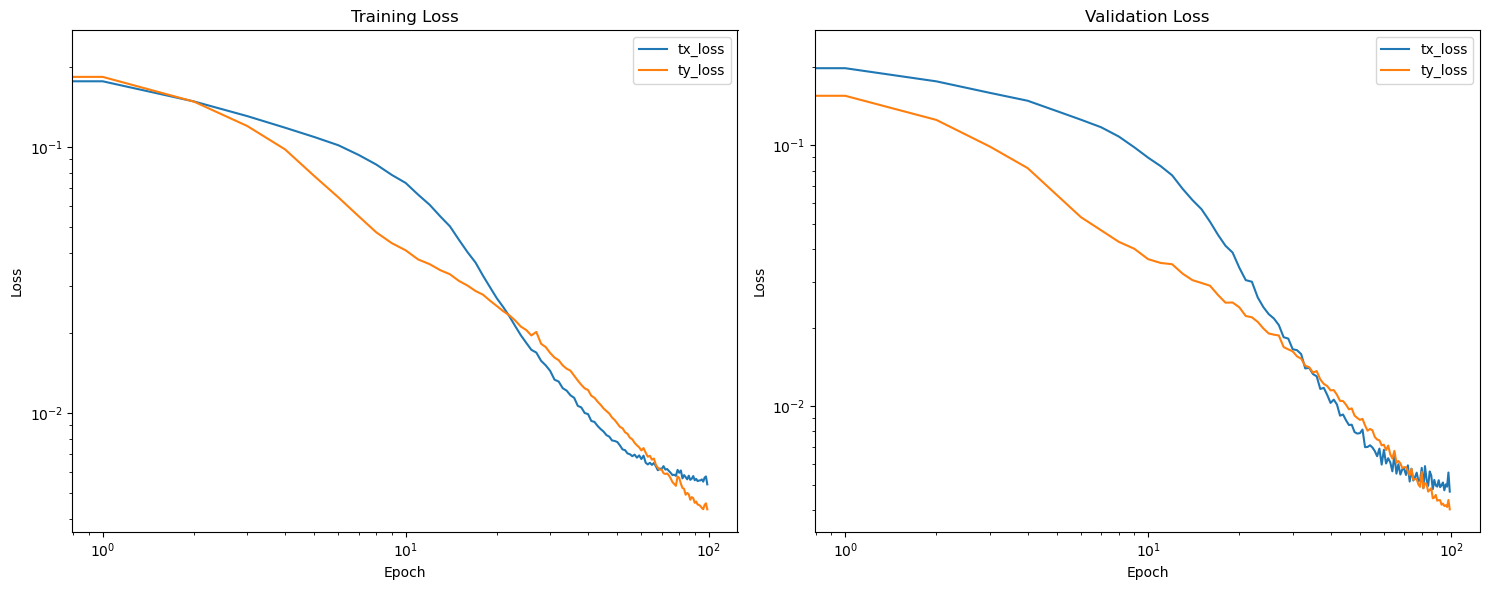

In [57]:
# Define separate branches for each output
tx_output = Dense(1, activation='swish', name='tx')(input_layer_C_2)
ty_output = Dense(1, activation='swish', name='ty')(input_layer_C_2)

# Combine the outputs into a single model
model_C_2 = Model(inputs=input_layer_C_2, outputs=[tx_output, ty_output])

# Compile the model
model_C_2.compile(optimizer='adam', 
              loss=losses_dict_C_2,
              metrics=metrics_dict_C_2)

# Implement ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_2 = model_C_2.fit(X_train_C_2, Y_train_distribution_C_2,
          epochs=100, batch_size=32, validation_data = (X_test_C_2, Y_test_distribution_C_2), callbacks=[reduce_lr])

plot_loss(history_C_2)

In [ ]:
# Evaluate the model on the test set
evaluation_results = model_C_2.evaluate(X_test_C_2, Y_test_distribution_C_2, batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_2.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

2/2 [==============================] - 0s 5ms/step - loss: 0.0087 - tx_loss: 0.0047 - ty_loss: 0.0040 - tx_mae: 0.0543 - ty_mae: 0.0492
Metrics on Test Set:
loss: 0.008722600527107716
tx_loss: 0.0047013359144330025
ty_loss: 0.004021264612674713
tx_mae: 0.054290223866701126
ty_mae: 0.04917580261826515


This code defines and trains a neural network model for a regression task with two outputs (tx and ty).
Different activation functions are used for the output layers to explore their impact on performance.

| Activation Function | MAE for 'tx' | MAE for 'ty' |
|----------------------|--------------|--------------|
| Linear               | 0.056        | 0.049        |
| ReLU                 | 0.056        | 0.047        |
| Leaky ReLU           | 0.056        | 0.048        |
| Swish                | 0.054        | 0.046        |
| Softplus             | 0.055        | 0.046        |
| Tanh                 | 0.064        | 0.052        |

Following our measurements, we chose to use the swish activation function as it performs the best. The marginal variations in performance can be attributed to the characteristics of each activation function, with Swish demonstrating a slight advantage in capturing the complexities of the output layer patterns.



### 2. Tuning the model's layers and hyperparameters

#### Cross-validation

In order to find the best hyperparameters for this model, we tried using cross-validation via grid search to test all the possible combinations for our model.  We chose sets of hyperparameters widely used for this kind of neural networks model for regressional outputs.
  
| Parameter                     | Purpose                                     |
|-------------------------------|---------------------------------------------|
| Learning Rate (`learning_rate`)       | Determines the step size during optimization. |
| Activation Function (`activation`)   | Introduces non-linearity to the model.        |
| Number of Epochs (`epochs`)          | Defines the number of training iterations.    |
| Batch Size (`batch_size`)            | Specifies number of samples in one iteration. |
| Factor for Reducing LR (`factor`)    | Reduces learning rate when performance plateaus. |
| Patience for LR Reduction (`patience`)| Epochs with no improvement before LR reduction. |
| Minimum Learning Rate (`min_lr`)     | Lower bound on learning rate during training.  |  

The cross-validation took 160 minutes to compile for a 20 seconds original run-time code. Even with all the possibilities of hyperparameter combinations, the loss has not been improved compared to our original implementation.

As seen before, cross-validation using GridSearch is not effective at all as it requires a lot of computation time. We defined, hence, a tuner to find the best hyperparameters for our models, including the layers to use. This method improved the general loss and is computationally faster. This is the method we use for our other models.

In [63]:
# Define the tuner directory
tuner_dir_C_2 = 'my_dir/multi_output_tuning_reduced_C_2'
retrain_tuner(tuner_dir_C_2, re_run=True)

# Define the build_model function for hyperparameter tuning
def build_model_C_2(hp):
    input_layer_C_2 = Input(shape=(X_train_C_2.shape[1],))
    x = input_layer_C_2

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=128, step=32),
                  activation=hp.Choice('activation_' + str(i), values=['relu', 'swish', 'linear']),
                  kernel_regularizer=l1_l2(l1=hp.Float('l1', min_value=1e-5, max_value=1e-3, sampling='LOG'),
                                           l2=hp.Float('l2', min_value=1e-5, max_value=1e-3, sampling='LOG')))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=hp.Float('leaky_alpha_' + str(i), min_value=0.01, max_value=0.3, step=0.05))(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1))(x)

    # Output layers
    tx_output = Dense(1, activation='swish', name='tx')(x)
    ty_output = Dense(1, activation='swish', name='ty')(x)

    model_C_2 = Model(inputs=input_layer_C_2, outputs=[tx_output, ty_output])

    # Learning rate schedule
    lr_schedule = learning_rate(hp)

    model_C_2.compile(optimizer=Adam(learning_rate=lr_schedule),
                      loss=losses_dict_C_2,
                      metrics=metrics_dict_C_2)

    return model_C_2

# Create a tuner instance for hyperparameter tuning
tuner_C_2 = kt.Hyperband(build_model_C_2,
                        objective = kt.Objective("val_loss", direction="min"),
                        max_epochs=15,
                        factor=5,
                        directory='my_dir',
                        project_name='multi_output_tuning_reduced_C_2')

# Start the hyperparameter search
tuner_C_2.search(X_train_C_2, Y_train_distribution_C_2,
                epochs=100,
                validation_data=(X_test_C_2, Y_test_distribution_C_2))

# Get the best hyperparameters
best_hps_C_2 = tuner_C_2.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner_C_2.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
eval_result = best_model.evaluate(X_test_C_2, Y_test_distribution_C_2)

Trial 13 Complete [00h 00m 07s]
val_loss: 0.8056713342666626

Best val_loss So Far: 0.27297431230545044
Total elapsed time: 00h 01m 54s
2/2 [==============================] - 1s 5ms/step - loss: 0.2730 - tx_loss: 0.1574 - ty_loss: 0.0560 - tx_mae: 0.3335 - ty_mae: 0.1990
Evaluation result on Test Data: [0.27297431230545044, 0.15736699104309082, 0.05598721653223038, 0.33350545167922974, 0.19899006187915802]


In [64]:
# Re-train the best model
best_hps = tuner_C_2.get_best_hyperparameters(num_trials=1)[0]
model_C_2 = build_model_C_2(best_hps)
history_C_2 = model_C_2.fit(X_train_C_2, Y_train_distribution_C_2,
                    epochs=110,
                    validation_data=(X_test_C_2, Y_test_distribution_C_2))

# Evaluate the model on the test set
evaluation_results_C_2 = model_C_2.evaluate(X_test_C_2, Y_test_distribution_C_2, batch_size=32)

Epoch 1/110
5/5 [==============================] - 3s 171ms/step - loss: 0.9537 - tx_loss: 0.4089 - ty_loss: 0.4789 - tx_mae: 0.5458 - ty_mae: 0.6125 - val_loss: 0.6835 - val_tx_loss: 0.1932 - val_ty_loss: 0.4244 - val_tx_mae: 0.4001 - val_ty_mae: 0.5972
Epoch 2/110
5/5 [==============================] - 0s 24ms/step - loss: 0.9992 - tx_loss: 0.4219 - ty_loss: 0.5114 - tx_mae: 0.5539 - ty_mae: 0.5920 - val_loss: 0.7829 - val_tx_loss: 0.3081 - val_ty_loss: 0.4087 - val_tx_mae: 0.5339 - val_ty_mae: 0.5840
Epoch 3/110
5/5 [==============================] - 0s 28ms/step - loss: 0.7887 - tx_loss: 0.3725 - ty_loss: 0.3500 - tx_mae: 0.5056 - ty_mae: 0.5112 - val_loss: 0.7739 - val_tx_loss: 0.3625 - val_ty_loss: 0.3451 - val_tx_mae: 0.5774 - val_ty_mae: 0.5397
Epoch 4/110
5/5 [==============================] - 0s 39ms/step - loss: 0.7522 - tx_loss: 0.3427 - ty_loss: 0.3432 - tx_mae: 0.4943 - ty_mae: 0.4975 - val_loss: 0.6286 - val_tx_loss: 0.2789 - val_ty_loss: 0.2833 - val_tx_mae: 0.5070 - va

Best Hyperparameters:
num_layers: 1
units_0: 64
activation_0: relu
l1: 5.472836126493525e-05
l2: 0.00015209460123717444
leaky_alpha_0: 0.16000000000000003
dropout_0: 0.30000000000000004
initial_learning_rate: 0.002830345538814358
tuner/epochs: 15
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
units_1: 64
activation_1: relu
leaky_alpha_1: 0.21000000000000002
dropout_1: 0.1
units_2: 96
activation_2: swish
leaky_alpha_2: 0.01
dropout_2: 0.4
---------------------------------------------
Metrics on Test Set:
loss: 0.05887821316719055
tx_loss: 0.005339288618415594
ty_loss: 0.003355185966938734
tx_mae: 0.054890621453523636
ty_mae: 0.045021187514066696


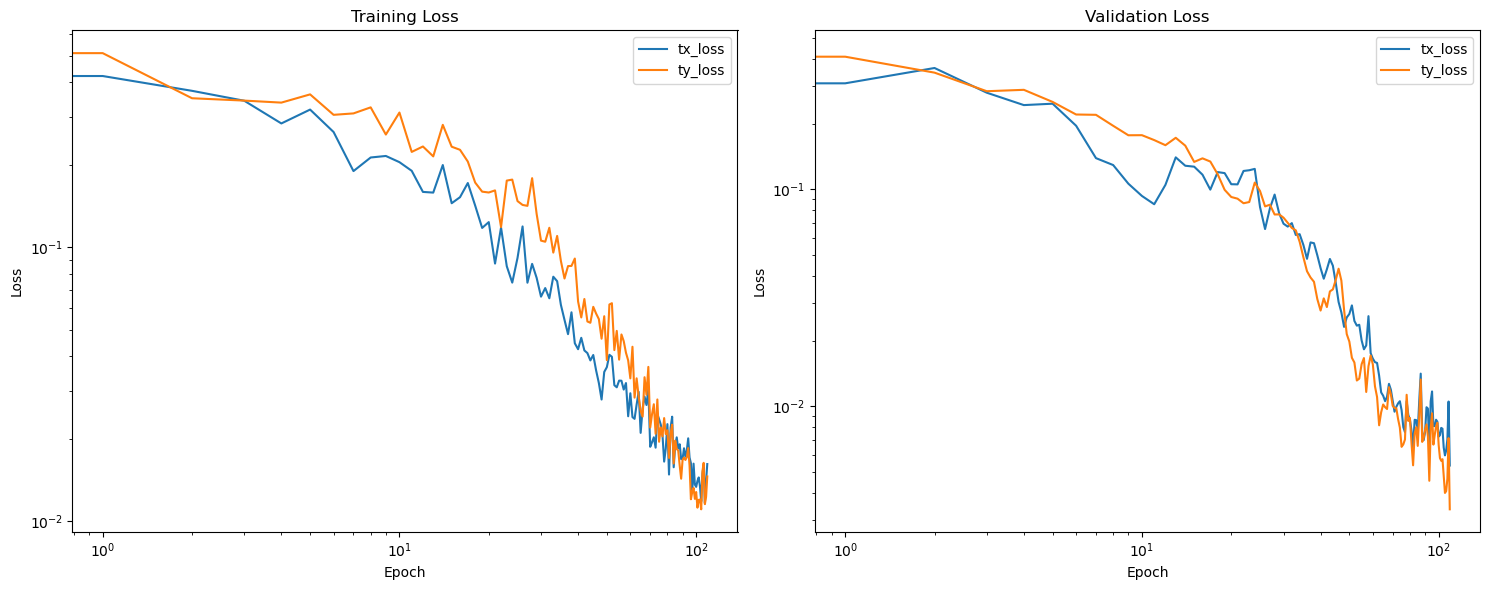

In [65]:
# Print the evaluation results and best hyperparameters
print_results(best_hps, model_C_2, evaluation_results_C_2)
# Plot loss curves
plot_loss(history_C_2)

## 3. Predicting Building Safety (Type D)

In [66]:
X_train_D = df = pd.read_csv(path + "X_train_D_FE.csv", low_memory=False)
X_test_D = pd.read_csv(path + "X_test_D_FE.csv", low_memory=False)

Y_train_D = df = pd.read_csv(path + "Y_train_d_FE.csv", low_memory=False)
Y_test_D = pd.read_csv(path + "Y_test_D_FE.csv", low_memory=False)

# Change the column name because Python doesn't support special characters
column_names = ['omega_x', 'omega_y', 'mu_x', 'mu_y', 'cmr', 'ssf','acmr', 'io-ln', 'io-b', 'ls-ln', 'ls-b', 'cp-ln', 'cp-b']
Y_train_D.columns = column_names
Y_test_D.columns = column_names

In [ ]:
# Defining constants
input_layer_D = Input(shape=(X_train_D.shape[1],))

losses_dict_D = {
    'omega_x': 'mean_squared_error',
    'omega_y': 'mean_squared_error',
    'mu_x': 'mean_squared_error',
    'mu_y': 'mean_squared_error',
    'cmr': 'mean_squared_error',
    'ssf': 'mean_squared_error',
    'acmr': 'mean_squared_error',
    'io-ln': 'mean_squared_error',
    'io-b': 'mean_squared_error',
    'ls-ln': 'mean_squared_error',
    'ls-b': 'mean_squared_error',
    'cp-ln': 'mean_squared_error',
    'cp-b': 'mean_squared_error'
}
metrics_dict_D = {
    'omega_x': 'mae',
    'omega_y': 'mae',
    'mu_x': 'mae',
    'mu_y': 'mae',
    'cmr': 'mae',
    'ssf': 'mae',
    'acmr': 'mae',
    'io-ln': 'mae',
    'io-b': 'mae',
    'ls-ln': 'mae',
    'ls-b': 'mae',
    'cp-ln': 'mae',
    'cp-b': 'mae'
}

Y_train_distribution_D = {
    'omega_x': Y_train_D['omega_x'],
    'omega_y': Y_train_D['omega_y'],
    'mu_x': Y_train_D['mu_x'],
    'mu_y': Y_train_D['mu_y'],
    'cmr': Y_train_D['cmr'],
    'ssf': Y_train_D['ssf'],
    'acmr': Y_train_D['acmr'],
    'io-ln': Y_train_D['io-ln'],
    'io-b': Y_train_D['io-b'],
    'ls-ln': Y_train_D['ls-ln'],
    'ls-b': Y_train_D['ls-b'],
    'cp-ln': Y_train_D['cp-ln'],
    'cp-b': Y_train_D['cp-b']
}

Y_test_distribution_D = {
    'omega_x': Y_test_D['omega_x'],
    'omega_y': Y_test_D['omega_y'],
    'mu_x': Y_test_D['mu_x'],
    'mu_y': Y_test_D['mu_y'],
    'cmr': Y_test_D['cmr'],
    'ssf': Y_test_D['ssf'],
    'acmr': Y_test_D['acmr'],
    'io-ln': Y_test_D['io-ln'],
    'io-b': Y_test_D['io-b'],
    'ls-ln': Y_test_D['ls-ln'],
    'ls-b': Y_test_D['ls-b'],
    'cp-ln': Y_test_D['cp-ln'],
    'cp-b': Y_test_D['cp-b']
}


#### 1. Base implementation

Epoch 1/100
5/5 [==============================] - 6s 417ms/step - loss: 114.9311 - omega_x_loss: 27.6339 - omega_y_loss: 33.3359 - mu_x_loss: 16.0565 - mu_y_loss: 21.8167 - cmr_loss: 4.3860 - ssf_loss: 0.7301 - acmr_loss: 8.6354 - io-ln_loss: 1.0664 - io-b_loss: 0.0759 - ls-ln_loss: 0.2200 - ls-b_loss: 0.1098 - cp-ln_loss: 0.6913 - cp-b_loss: 0.1732 - omega_x_mae: 4.6066 - omega_y_mae: 5.1001 - mu_x_mae: 3.8297 - mu_y_mae: 4.5979 - cmr_mae: 1.8938 - ssf_mae: 0.7137 - acmr_mae: 2.6350 - io-ln_mae: 0.8362 - io-b_mae: 0.2199 - ls-ln_mae: 0.3781 - ls-b_mae: 0.2673 - cp-ln_mae: 0.6369 - cp-b_mae: 0.3314 - val_loss: 95.6539 - val_omega_x_loss: 23.8512 - val_omega_y_loss: 30.7003 - val_mu_x_loss: 14.1076 - val_mu_y_loss: 17.2722 - val_cmr_loss: 2.3917 - val_ssf_loss: 0.6514 - val_acmr_loss: 5.5369 - val_io-ln_loss: 0.3743 - val_io-b_loss: 0.0553 - val_ls-ln_loss: 0.1881 - val_ls-b_loss: 0.0644 - val_cp-ln_loss: 0.3657 - val_cp-b_loss: 0.0948 - val_omega_x_mae: 3.9677 - val_omega_y_mae: 4.725

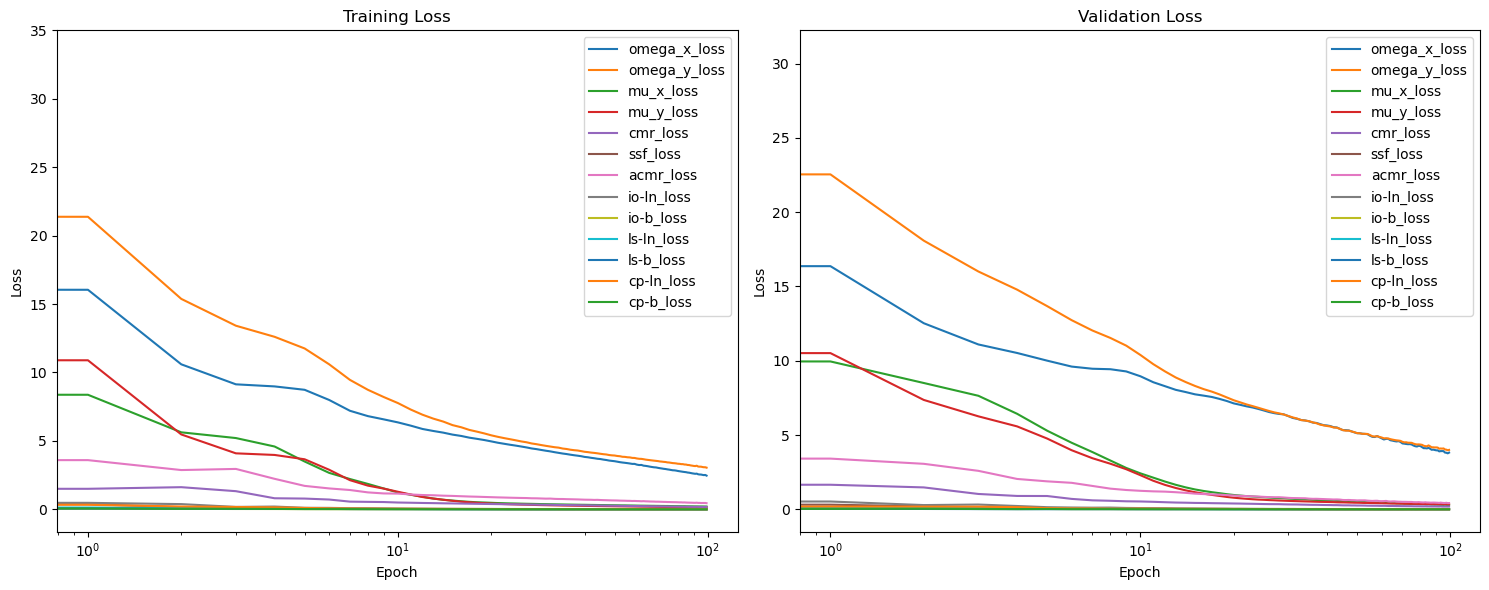

In [13]:
# Define separate branches for each output
omega_x_output = Dense(1, activation='linear', name='omega_x')(input_layer_D)
omega_y_output = Dense(1, activation='linear', name='omega_y')(input_layer_D)
mu_x_output = Dense(1, activation='linear', name='mu_x')(input_layer_D)
mu_y_output = Dense(1, activation='linear', name='mu_y')(input_layer_D)
cmr_output = Dense(1, activation='linear', name='cmr')(input_layer_D)
ssf_output = Dense(1, activation='linear', name='ssf')(input_layer_D)
acmr_output = Dense(1, activation='linear', name='acmr')(input_layer_D)
io_ln_output = Dense(1, activation='linear', name='io-ln')(input_layer_D)
io_b_output = Dense(1, activation='linear', name='io-b')(input_layer_D)
ls_ln_output = Dense(1, activation='linear', name='ls-ln')(input_layer_D)
ls_b_output = Dense(1, activation='linear', name='ls-b')(input_layer_D)
cp_ln_output = Dense(1, activation='linear', name='cp-ln')(input_layer_D)
cp_b_output = Dense(1, activation='linear', name='cp-b')(input_layer_D)

# Combine the outputs into a single model
model_D = Model(inputs=input_layer_D, outputs=[omega_x_output, omega_y_output, 
                                               mu_x_output, mu_y_output,
                                               cmr_output, ssf_output, acmr_output,
                                               io_ln_output, io_b_output,
                                               ls_ln_output, ls_b_output,
                                               cp_ln_output, cp_b_output])

# Compile the model
model_D.compile(optimizer='adam', 
              loss=losses_dict_D,
              metrics=metrics_dict_D)

# Train the model
history_D = model_D.fit(X_train_D, Y_train_distribution_D,
                                    epochs=100, 
                                    batch_size=32, 
                                    validation_data=(X_test_D, Y_test_distribution_D))

plot_loss(history_D)

In [12]:
# Evaluate the model on the test set
evaluation_results = model_D.evaluate(X_test_D, Y_test_distribution_D, batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_D.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

2/2 [==============================] - 0s 0s/step - loss: 9.1341 - omega_x_loss: 3.8506 - omega_y_loss: 4.0143 - mu_x_loss: 0.3052 - mu_y_loss: 0.3383 - cmr_loss: 0.1681 - ssf_loss: 0.0106 - acmr_loss: 0.4051 - io-ln_loss: 0.0100 - io-b_loss: 0.0061 - ls-ln_loss: 0.0058 - ls-b_loss: 0.0045 - cp-ln_loss: 0.0110 - cp-b_loss: 0.0047 - omega_x_mae: 1.2280 - omega_y_mae: 1.4469 - mu_x_mae: 0.4442 - mu_y_mae: 0.3904 - cmr_mae: 0.2987 - ssf_mae: 0.0774 - acmr_mae: 0.4675 - io-ln_mae: 0.0820 - io-b_mae: 0.0611 - ls-ln_mae: 0.0587 - ls-b_mae: 0.0531 - cp-ln_mae: 0.0731 - cp-b_mae: 0.0525
Metrics on Test Set:
loss: 9.134135246276855
omega_x_loss: 3.850623607635498
omega_y_loss: 4.014266014099121
mu_x_loss: 0.30517154932022095
mu_y_loss: 0.3382880687713623
cmr_loss: 0.16806285083293915
ssf_loss: 0.010556302964687347
acmr_loss: 0.40513163805007935
io-ln_loss: 0.010006560012698174
io-b_loss: 0.006092808209359646
ls-ln_loss: 0.005768786184489727
ls-b_loss: 0.004469545092433691
cp-ln_loss: 0.01096167

There are multiple layers that can be tested for our models. By testing different combinations of layers using iterational validation, the main results are the following:

| Metric         | Batch Normalization         | Only Dense Layers           | Hidden Layers               |
|----------------|-----------------------------|-----------------------------|-----------------------------|
| omega_x_mae    | 1.200                       | 1.178                       | 1.228                       |
| omega_y_mae    | 1.424                       | 1.464                       | 1.447                       |
| mu_x_mae       | 0.453                       | 0.425                       | 0.444                       |
| mu_y_mae       | 0.389                       | 0.399                       | 0.390                       |
| cmr_mae        | 0.314                       | 0.336                       | 0.299                       |
| ssf_mae        | 0.081                       | 0.069                       | 0.077                       |
| acmr_mae       | 0.475                       | 0.511                       | 0.467                       |
| io-ln_mae      | 0.090                       | 0.063                       | 0.082                       |
| io-b_mae       | 0.052                       | 0.063                       | 0.061                       |
| ls-ln_mae      | 0.074                       | 0.082                       | 0.059                       |
| ls-b_mae       | 0.057                       | 0.051                       | 0.053                       |
| cp-ln_mae      | 0.091                       | 0.070                       | 0.073                       |
| cp-b_mae       | 0.063                       | 0.042                       | 0.052                       |

We can clearly observe that the best combination of layers is to use only dense layers for creating our output ones. We can understand this result by comprehending the simplicity and expressiveness these layers offer. In cases where the dataset's relationships are relatively straightforward and can be captured by linear models, the additional complexity introduced by bacth normalization or hidden layers may not be necessary. The absence of these components reduces overhead, streamlining and may contribute to more stable convergence. 

#### 2. Tuning the model's layers and hyperparameters

In [76]:
# Define the tuner directory
tuner_dir_D = 'my_dir/multi_output_tuning_reduced_D'

# Check if the directory exists and delete it
if os.path.exists(tuner_dir_D):
    shutil.rmtree(tuner_dir_D)

# Define the build_model function for hyperparameter tuning
def build_model_D(hp):
    input_layer_D = Input(shape=(X_train_D.shape[1],))
    x = input_layer_D

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                  activation=hp.Choice('activation_' + str(i), values=['relu', 'swish', 'linear', 'softmax']),
                  kernel_regularizer=l1_l2(l1=hp.Float('l1', min_value=1e-5, max_value=1e-3, sampling='LOG'),
                                           l2=hp.Float('l2', min_value=1e-5, max_value=1e-3, sampling='LOG')))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=hp.Float('leaky_alpha_' + str(i), min_value=0.01, max_value=0.3, step=0.05))(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1))(x)

    # Define separate branches for each output
    outputs = []
    for output_name in Y_train_D.columns:
        output = Dense(1, activation='linear', name=output_name)(x)
        outputs.append(output)

    # Combine the outputs into a single model
    model_D = Model(inputs=input_layer_D, outputs=outputs)

    # Learning rate schedule
    lr_schedule = learning_rate(hp)

    # Compile the model
    model_D.compile(optimizer=Adam(learning_rate=lr_schedule),
                    loss=losses_dict_D,
                    metrics=metrics_dict_D)

    return model_D

# Create a tuner instance for hyperparameter tuning
tuner_D = kt.Hyperband(build_model_D,
                      objective=kt.Objective("val_loss", direction="min"),
                      max_epochs=15,
                      factor=5,
                      directory='my_dir_D',
                      project_name='multi_output_tuning_reduced_D')

# Start the hyperparameter search
tuner_D.search(X_train_D, Y_train_distribution_D,
              epochs=100,
              validation_data=(X_test_D, Y_test_distribution_D))

# Get the best hyperparameters
best_hps_D = tuner_D.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model_D = build_model_D(best_hps_D)

# Evaluate the best model on the test set
evaluation_results_D = best_model_D.evaluate(X_test_D, Y_test_distribution_D, batch_size=32)

Trial 13 Complete [00h 00m 13s]
val_loss: 31.539356231689453

Best val_loss So Far: 31.539356231689453
Total elapsed time: 00h 03m 07s
2/2 [==============================] - 2s 5ms/step - loss: 156.0397 - omega_x_loss: 45.7616 - omega_y_loss: 42.4447 - mu_x_loss: 21.0302 - mu_y_loss: 24.1884 - cmr_loss: 6.9781 - ssf_loss: 1.0158 - acmr_loss: 11.8644 - io-ln_loss: 0.7308 - io-b_loss: 0.6269 - ls-ln_loss: 0.4698 - ls-b_loss: 0.1056 - cp-ln_loss: 0.3911 - cp-b_loss: 0.1475 - omega_x_mae: 6.0827 - omega_y_mae: 5.8496 - mu_x_mae: 4.5489 - mu_y_mae: 4.8569 - cmr_mae: 2.4928 - ssf_mae: 0.9482 - acmr_mae: 3.2558 - io-ln_mae: 0.7415 - io-b_mae: 0.7232 - ls-ln_mae: 0.5045 - ls-b_mae: 0.2676 - cp-ln_mae: 0.5138 - cp-b_mae: 0.3280


In [77]:
# Re-train the best model for Model D
best_hps_D = tuner_D.get_best_hyperparameters(num_trials=1)[0]
model_D = build_model_D(best_hps_D)
history_D = model_D.fit(X_train_D, Y_train_distribution_D,
                        epochs=200,
                        validation_data=(X_test_D, Y_test_distribution_D))

# Evaluate the model on the test set for Model D
evaluation_results_D = model_D.evaluate(X_test_D, Y_test_distribution_D, batch_size=32)


Epoch 1/200
5/5 [==============================] - 8s 613ms/step - loss: 151.3757 - omega_x_loss: 24.8646 - omega_y_loss: 41.1054 - mu_x_loss: 20.8945 - mu_y_loss: 26.9574 - cmr_loss: 4.2721 - ssf_loss: 4.0633 - acmr_loss: 19.3481 - io-ln_loss: 2.1640 - io-b_loss: 1.4040 - ls-ln_loss: 1.2513 - ls-b_loss: 2.0032 - cp-ln_loss: 1.3807 - cp-b_loss: 1.3792 - omega_x_mae: 4.2606 - omega_y_mae: 5.8417 - mu_x_mae: 4.3868 - mu_y_mae: 5.0261 - cmr_mae: 1.6195 - ssf_mae: 1.7380 - acmr_mae: 4.0922 - io-ln_mae: 1.1956 - io-b_mae: 0.9425 - ls-ln_mae: 0.9000 - ls-b_mae: 1.1073 - cp-ln_mae: 0.9393 - cp-b_mae: 0.9379 - val_loss: 127.6001 - val_omega_x_loss: 24.0631 - val_omega_y_loss: 42.0565 - val_mu_x_loss: 16.3905 - val_mu_y_loss: 20.7184 - val_cmr_loss: 2.6819 - val_ssf_loss: 1.7073 - val_acmr_loss: 16.5408 - val_io-ln_loss: 0.1906 - val_io-b_loss: 0.4657 - val_ls-ln_loss: 0.1250 - val_ls-b_loss: 0.3157 - val_cp-ln_loss: 0.2893 - val_cp-b_loss: 1.7624 - val_omega_x_mae: 4.1155 - val_omega_y_mae: 5.

Best Hyperparameters:
num_layers: 1
units_0: 64
activation_0: relu
l1: 5.472836126493525e-05
l2: 0.00015209460123717444
leaky_alpha_0: 0.16000000000000003
dropout_0: 0.30000000000000004
initial_learning_rate: 0.002830345538814358
tuner/epochs: 15
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
units_1: 64
activation_1: relu
leaky_alpha_1: 0.21000000000000002
dropout_1: 0.1
units_2: 96
activation_2: swish
leaky_alpha_2: 0.01
dropout_2: 0.4
---------------------------------------------
Metrics on Test Set:
loss: 4.717516899108887
omega_x_loss: 1.6272366046905518
omega_y_loss: 1.5280511379241943
mu_x_loss: 0.3138401508331299
mu_y_loss: 0.30941304564476013
cmr_loss: 0.1363186091184616
ssf_loss: 0.00830004084855318
acmr_loss: 0.2281828671693802
io-ln_loss: 0.023469574749469757
io-b_loss: 0.002159417374059558
ls-ln_loss: 0.019402414560317993
ls-b_loss: 0.0022612791508436203
cp-ln_loss: 0.017885206267237663
cp-b_loss: 0.002653606701642275
omega_x_mae: 0.95348435640

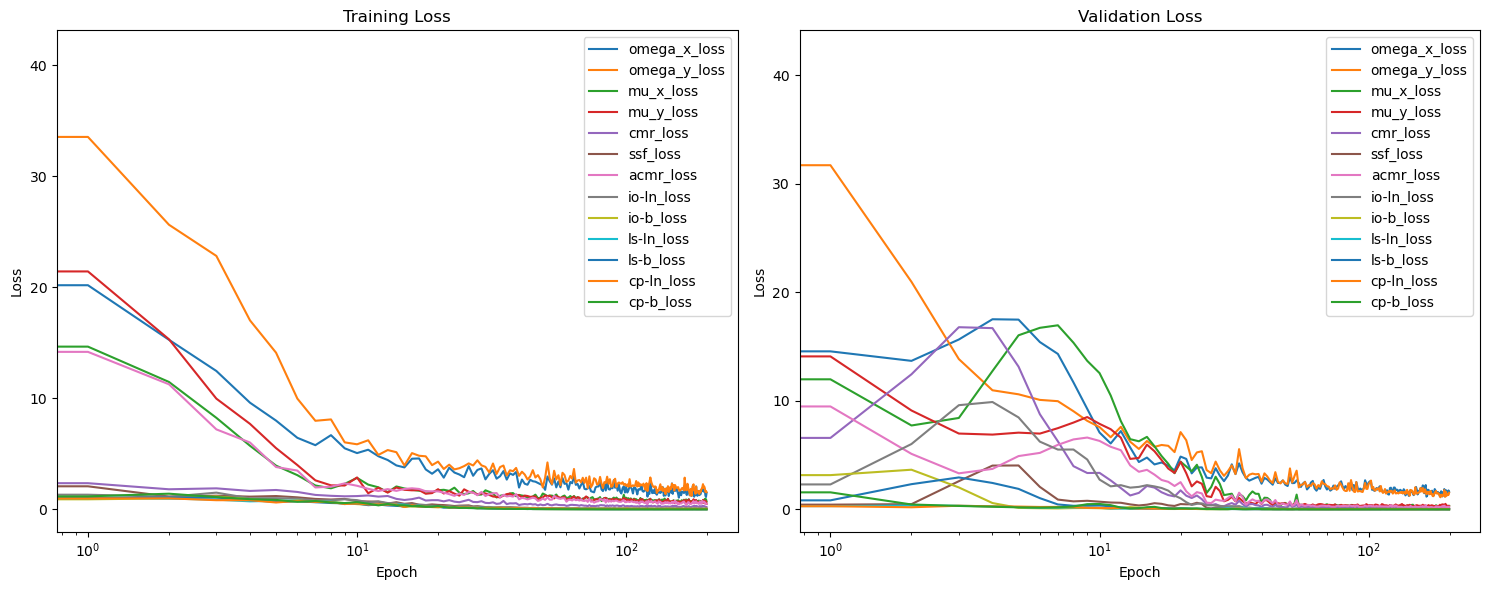

In [78]:
# Print the evaluation results and best hyperparameters for Model D
print_results(best_hps_D, model_D, evaluation_results_D)
# Plot loss curves for Model D
plot_loss(history_D)